# Braided River SP - Full workflow

This notebook is intended to serve as an example workflow for reproducing results within the main paper: ´DOI_TO_PAPER´. It can also be used as a starting point for producing your own BraidedRiverSP results for a river of your interest.

To run this notebook you will need to provide a binary geotiff representing the watermask from which the centerlines should be drawn and your own SWOT PIXC data for the dates of analysis. You should also provide a simplified main centerline and river starting line which can both be hand drawn, in order to facilitate reach labeling and connections.

In [1]:
import os
os.chdir('..')
print(os.getcwd())

from braidedSP.river import River

c:\Users\cwch\Tools\braided_rivers


## Creating River object

First we load in the river bounds and prior information on the river area of interest.

- `river_bounds`: a shapefile or geojson with a single feature bounding the river network. This is useful for ensuring that the river is clipped and limited to the area you wish to perform the analysis within
- `starting_line`: a shapefile or geojson with a single feature detailing the starting point of the river network. This is used to start the algorithm that connects and labels individual reaches
- `main_centerline`: a shapefile or geojson with a single feature detailing the general flow and direction of the river. This is used to ensure that centerlines are properly joined to the down stream reach though the downstream reach attribute

Finally we provide a path in which to dave the outputs and progress checks of the processing workflow

In [2]:
import geopandas as gpd

# set paths for aoi and out directory
river_bounds = gpd.read_file(r".\data\priors\brahmaputra_aoi.shp")

# Additional steps for labeling
starting_line = gpd.read_file(r".\data\priors\brahmaputra_starting_line\brahmaputra_starting_line.shp")
main_centerline = gpd.read_file(r".\data\priors\brahmaputra_single_centerline\brahmaputra_single_centerline.shp")

# output for progress and file shapes
odir = r".\data\odir\brahmaputra"

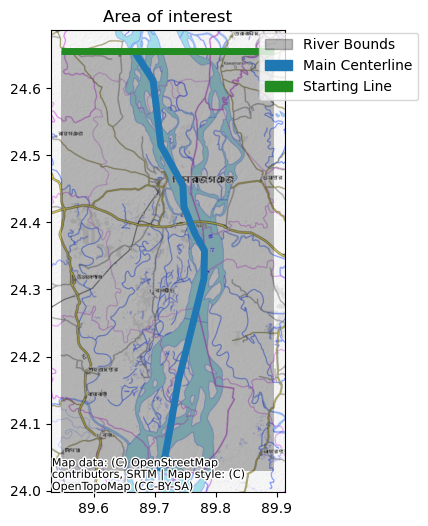

In [3]:
# quickly look at input data

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

fig, ax = plt.subplots(figsize=(8, 6))
ax.set(title='Area of interest')

river_bounds.plot(ax=ax, facecolor=(0.1, 0.1, 0.1, 0.3))
main_centerline.plot(ax=ax, linewidth=5, color='tab:blue')
starting_line.plot(ax=ax, linewidth=5, color='forestgreen')

legend_elements = [
    mpatches.Patch(color=(0.1, 0.1, 0.1, 0.3), label='River Bounds'),
    mpatches.Patch(color='tab:blue', label='Main Centerline'),
    mpatches.Patch(color='forestgreen', label='Starting Line')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1.6, 1.01))

cx.add_basemap(ax, source=cx.providers.OpenTopoMap, crs=river_bounds.crs.to_epsg()) # Or specify a different CRS if needed
plt.show()

The code is strucutred in a way that multiple masks and centerlines can be processed for an individual river system. For example we can analyze the differences in river channels from high and low flow seasons. 

We start by creating a `River` class which will manage all of the masks and processing workflow. You only need to provide a river name (used to create files that are unique to this rivers area of interest), the river bounds and the out directory

In [4]:
bramaputra = River(
    name='Brahmaputra',
    aoi=river_bounds,
    outdir=odir
)

## Adding masks to river

Adding masks for processing is as easy as using the `River.add_mask()` function. You should provide the path the the mask you wish to process and the date associated with that mask (maily used for organizing files with meaningful file names). You can add multiple masks to process many at once. It is recommended to provide masks that are slightly larger than you area of interest as centerlines could be shortened due to the pruning algorithms.

Here we will add a mask for low flows occuring in february and high flows occuring around september in the Bramaputra. First we plot them so we have an idea of how the centerlines might differ between the two, then we add them to the River object.

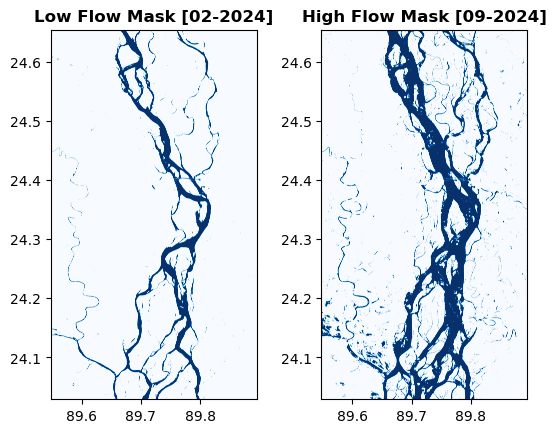

In [5]:
import rasterio
from rasterio.plot import show

low_flow_path = r".\data\watermasks\S2_WaterMask_NDWI_0224.tif"
high_flow_path = r".\data\watermasks\S2_WaterMask_NDWI_0924.tif"

# Briefly inspect water masks
fig, axes = plt.subplots(ncols=2)

with rasterio.open(low_flow_path) as src:
    show(src, ax=axes[0], title="Low Flow Mask [02-2024]", cmap='Blues')
         
with rasterio.open(high_flow_path) as src:
    show(src, ax=axes[1], title="High Flow Mask [09-2024]", cmap='Blues')

plt.show()

In [6]:
from datetime import datetime

bramaputra.add_mask(low_flow_path, datetime(2024, 2, 1))
bramaputra.add_mask(high_flow_path, datetime(2024, 9, 1))

## Processing masks to generate centerline rasters

Once you have added all the masks you wish to process to the river, you can process them in sequence with the `River.process_masks()` function. Here you can provide one dictionary with processing kwargs to be applied to all masks, or a list of kwarg dictionaries with parameters sets corresponding ot the order in which the masks were added.

Here is a short explaination of the parameters that can be provided.
- **dilate** [int or float]: describes the dilations to perform. Units is in pixels and corresponds to the kernel size provided to the `footprint` argument in `skimage.morphology.binary_dilation` In this example, we are using a mask at 10 meter resolution, so a value of 10 relates to a 100 meter dilation. Setting the value to zero, results in no dilation being performed.

- **erode** [int or float]: same as the dilate argument above, but for the erosion performed after the dialtion. *Note: this feature is not used within the paper, but can often help prevent oversimplification of the river centerlines when dealing with clear river channels in close proximity to one another*

- **gauss** [int or float]: the `sigma` parameter provided to `skimage.filters.gaussian`

- **gauss_thresh** [int or float]: a threshold parameter used to binarize the results after the gaussian fileter is performed.

- **second_dilation** [bool]: whether to perform a second set of dilation and erosions after the gaussian filter using the same `dilate` and `erosion` parameters supplied for first set.

- **fill_hole_size** [int or float]: the minimum size of holes to be left in binary image. *Note: this parameter is defined differently from paper as it performs the hole filling operation before skeletonization. This leads to a more interpretable parameter for the user as an assesment can be made before processing as to the minimum zise hole to remain.*

- **distance_threshold** [int or float]: the threshold used to connect neighboring pixels and label reaches.

- **prune_thresh** [int or float]: only branches shorter than this threshold will be candidates for pruning. Units are in meters

- **show_progress** [bool]: whether to show tqdm progress bars when performing algorthim

- **save_progress** [bool]: whether to save rasters of progess during the processing of the mask

In [ ]:
# Here we wish to apply a larger gaussian filter to the images for the high flow and include a larger fill hole size, 
# as the high flow images tend to have more noise. THus we provide a list of two parameter dictionaries in the order of the masks we provided

bramaputra.process_masks(
    [
        {
            'dilate': 10,
            'erode': 0,
            'gauss' : 20,
            'gauss_thresh':0.6,
            'second_dilation' : True,
            'fill_hole_size' : 100,  
            'distance_threshold' : 100,
            'prune_thresh' : 600,     
            'show_progress' : True,
            'save_progress' : True
        },{
            'dilate': 10,
            'erode': 0,
            'gauss' : 30,
            'gauss_thresh':0.6,
            'second_dilation' : True,
            'fill_hole_size' : 300,  
            'distance_threshold' : 100,
            'prune_thresh' : 600,     
            'show_progress' : True,
            'save_progress' : True
        }
    ]
)

## Generating centerline vectors

We have now generated a raster representation of the centerlines and labeled the resulting branches within the raster. It is typically more helpful to represent these centerlines in a vector format, so in the following steps we will process and join the raster centerlines into a conencted vector format.

There is currently only on processing parameter for generating vectorized centerlines, which is the `show_progress` parameter.

Generating centerlines: 100%|██████████| 2/2 [03:44<00:00, 112.30s/it]


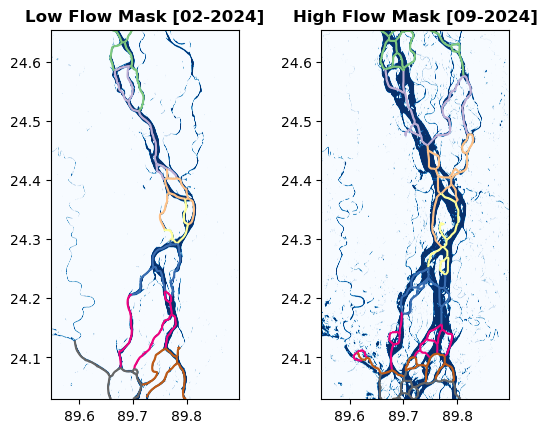

In [8]:
# Vectorize centerlines
bramaputra.generate_centerlines(
    {
        'show_progress' : True
    }
)

# Plot results
fig, axes = plt.subplots(ncols=2)

ax = axes[0]
with rasterio.open(low_flow_path) as src:
    show(src, ax=ax, title="Low Flow Mask [02-2024]", cmap='Blues')
bramaputra.centerlines[0].gdf.to_crs(4326).plot(column='branch_id', ax=ax, cmap='Accent')

ax = axes[1] 
with rasterio.open(high_flow_path) as src:
    show(src, ax=ax, title="High Flow Mask [09-2024]", cmap='Blues')
bramaputra.centerlines[1].gdf.to_crs(4326).plot(column='branch_id', ax=ax, cmap='Accent')

plt.show()

## Cleaning up centerlines

We could stop here, as we have generated a vector representation of the river centerlines, but it is typically more usefull to do a bit of post processing to ensure that the centerlines are easier to use for analysis of the river characteristics. Here we look at:
- Trimming the centerlines to the bounds of the AOI to ensure that there is are clear inflow and outlow points to the river system
- merging short centerlines into more meaningful unified descriptions of the river channel
- joining reaches at the reach inflow and outflow points (here called the joints)
    - When joining we also track which reaches a given reach flows into [helpful for generating 1D hydraulic model representations]

c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point_normalized
  return lib.line_locate_point_normalized(line, other)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point_normalized
  return lib.line_locate_point_normalized(line, other)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point_normalized
  return lib.line_locate_point_normalized(line, other)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point_normalized
  return lib.line_locate_point_normalized(line, other)
c:\Users\cwch\Tools\braided_rivers\.pixi\envs\default\lib\site-packages\shapely\linear.py:88: RuntimeWarning

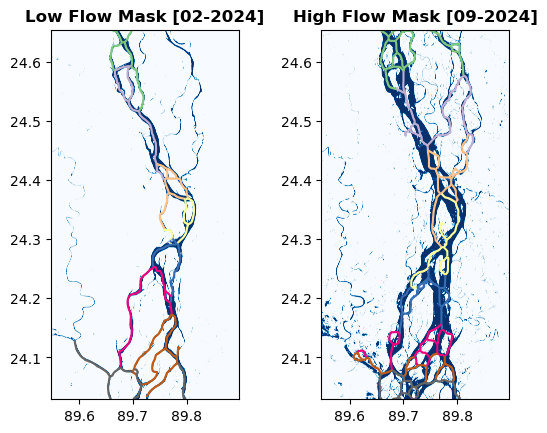

In [9]:
bramaputra.trim_centerlines_to_bounds()

bramaputra.merge_short_centerlines(
    {
        'connection_threshold' : 50,
        'similarity_threshold' : 0.7,
        'shortest_centerline' : 2000
    }
)

bramaputra.join_centerlines(
    {
        'starting_line' : starting_line,
        'main_centerline' : main_centerline,
        'search_dist' : 20
    }
)

# Plot results
fig, axes = plt.subplots(ncols=2)

ax = axes[0]
with rasterio.open(low_flow_path) as src:
    show(src, ax=ax, title="Low Flow Mask [02-2024]", cmap='Blues')
bramaputra.centerlines[0].gdf.to_crs(4326).plot(column='branch_id', ax=ax, cmap='Accent')

ax = axes[1] 
with rasterio.open(high_flow_path) as src:
    show(src, ax=ax, title="High Flow Mask [09-2024]", cmap='Blues')
bramaputra.centerlines[1].gdf.to_crs(4326).plot(column='branch_id', ax=ax, cmap='Accent')

plt.show()

## Saving generated centerlines

You can save your generated centerlines using the `River.export_centerlines()` function. You may specify any geopandas accepted vectorized format for export (shp, geojson) just enter the `file_type` suffix. The default is shp file.

In [10]:
bramaputra.export_centerlines(file_type='geojson')